<a href="https://colab.research.google.com/github/dropthejase/ml_training/blob/main/neural_networks/rnn_spamdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchtext.data as ttd

from torch.utils.data import Dataset, DataLoader


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# LOAD DATASET # 

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [ ]:
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

In [ ]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [ ]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df.iloc[:,:2]
df.columns = ['labels','data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df['b_labels'] = df['labels'].map({'ham':0,'spam':1})

In [ ]:
X = df['data']
y = df['b_labels']

# FUNCTIONS #

In [ ]:
# convert an array of sentences into an array of tokens
def word_to_token(words, word_dict):

  word2token = []

  for row in words:
    temp_list = []
    for word in tokenizer(row):
      if word in word_dict.keys():
        temp_list.append(word_dict[word])
      else:
        temp_list.append(word_dict['<unk>'])

    word2token.append(temp_list)

  return word2token


In [ ]:
def padding(X): # X is a tuple (list_of_tokenised_sentences, label)
  padded = []
  labels = []
  N = len(X)

  # find max length
  max_len = 0

  for row in X:
    if len(row[0]) > max_len:
      max_len = len(row[0])
    
  # apply padding
  for row in X:
    if len(row[0]) < max_len:
      for i in range(max_len - len(row[0])):
        row[0].insert(0, 0)

    padded.append(row[0])
    labels.append(row[1])

  # turn lists into tensors
  padded = torch.tensor(padded)
  labels = torch.tensor(labels)

  return padded, labels

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, data, labels, transform=None, target_transform=None):
    self.data = data
    self.labels = list(labels)
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):

    data = self.data[idx]
    labels = self.labels[idx]

    if self.transform:
        data = self.transform(data)
    if self.target_transform:
        labels = self.target_transform(labels)
    return data, labels

# LOAD DATASET #

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Create vocab matrix
from torchtext.data import get_tokenizer

tokenizer = get_tokenizer("basic_english")
tokens = []

for x in X_train:
  tokens += tokenizer(x)

tokens = list(set(tokens))

word_dict = {}

word_dict['<unk>'] = 0
word_dict['<pad>'] = 1

for i in range(2, len(tokens)+2):
  word_dict[tokens[i-2]] = i

In [ ]:
X_train_token = word_to_token(X_train, word_dict)
X_test_token = word_to_token(X_test, word_dict)

In [ ]:
len(X_train_token)

3733

In [ ]:
train_data = CustomDataset(X_train_token, y_train)
test_data = CustomDataset(X_test_token, y_test)

In [ ]:
batch_size=32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=padding)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=padding)

In [ ]:
for inputs, targets in train_loader:
  print(inputs.shape, targets.shape)
  break

torch.Size([32, 45]) torch.Size([32])


# RNN #

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
    super(RNN,self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.L = n_rnnlayers
    self.K = n_outputs

    self.embed = nn.Embedding(self.V, self.D)
    self.rnn = nn.LSTM(
        input_size = self.D,
        hidden_size = self.M,
        num_layers = self.L,
        batch_first=True
    )

    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # turns word indexes into word vectors - output N x V x D of word vector
    out = self.embed(X)
    # print(out.shape)

    # get RNN unit output
    out, _ = self.rnn(out, (h0, c0))

    out, _ = torch.max(out, 1)

    out = self.fc(out)
    return out

In [ ]:
len(word_dict)

7480

In [ ]:
model = RNN(len(word_dict), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(7480, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(model.parameters())

In [ ]:
n_epochs = 15

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):

  # training
  train_loss = []

  for inputs, targets in train_loader:
    
    targets = targets.view(-1, 1).float()

    inputs, targets = inputs.to(device), targets.to(device)

    optimiser.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, targets)

    loss.backward()
    optimiser.step()

    train_loss.append(loss.item())

  train_loss = np.mean(train_loss)

  # test
  test_loss = []

  for inputs, targets in test_loader:
    
    targets = targets.view(-1, 1).float()
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, targets)

    test_loss.append(loss.item())
  
  test_loss = np.mean(test_loss)

  # add losses
  train_losses[it] = train_loss
  test_losses[it] = test_loss

  print(f'Epoch: {it+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch: 1, Train Loss: 0.4935, Test Loss: 0.3898
Epoch: 2, Train Loss: 0.3311, Test Loss: 0.3125
Epoch: 3, Train Loss: 0.2366, Test Loss: 0.2334
Epoch: 4, Train Loss: 0.1590, Test Loss: 0.1977
Epoch: 5, Train Loss: 0.1156, Test Loss: 0.1725
Epoch: 6, Train Loss: 0.0902, Test Loss: 0.1653
Epoch: 7, Train Loss: 0.0732, Test Loss: 0.1543
Epoch: 8, Train Loss: 0.0592, Test Loss: 0.1552
Epoch: 9, Train Loss: 0.0507, Test Loss: 0.1601
Epoch: 10, Train Loss: 0.0459, Test Loss: 0.1505
Epoch: 11, Train Loss: 0.0339, Test Loss: 0.1570
Epoch: 12, Train Loss: 0.0289, Test Loss: 0.1504
Epoch: 13, Train Loss: 0.0255, Test Loss: 0.1530
Epoch: 14, Train Loss: 0.0228, Test Loss: 0.1560
Epoch: 15, Train Loss: 0.0203, Test Loss: 0.1560


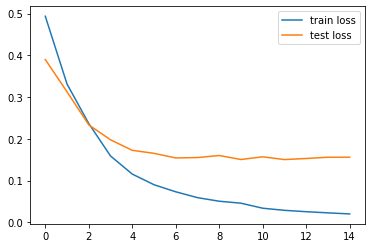

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
# Train Accuracy
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)
 
  p_train = model(inputs)
  predictions = (p_train > 0)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

# Test Accuracy
n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)
 
  p_test = model(inputs)
  predictions = (p_test > 0)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f'Train Accuracy: {train_acc: .4f}, Test Accuracy: {test_acc: .4f}')

Train Accuracy:  0.9962, Test Accuracy:  0.9560
